In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision import transforms
import os
from tqdm import tqdm
import matplotlib.pyplot as plt


class SingleLayerNN(nn.Module):
    def __init__(self):
        super(SingleLayerNN, self).__init__()
        self.fc = nn.Linear(1, 320)  
        self.out = nn.Linear(320, 1)

    def forward(self, x):
        x = torch.relu(self.fc(x)) 
        x = self.out(x)  
        return x

model = SingleLayerNN()


criterion = nn.MSELoss() 
optimizer = optim.Adam(model.parameters(), lr=0.01)  


In [26]:
def neuronalNeuralBalance(inl, oul):

    ninc = torch.zeros_like(inl.weight)
    noul = torch.zeros_like(oul.weight)

    for i in range(inl.weight.data.shape[0]):
        inc = torch.sum(torch.abs(inl.weight.data[i])).item()
        outg = torch.sum(torch.abs(oul.weight.data[:,i])).item()

        # outg = outg / float(len(oul.weight.data[:,i]))
        # inc = inc / float(len(inl.weight.data[i]))

        opt = np.sqrt(outg/inc)

        ninc[i] = inl.weight.data[i]*opt
        noul[:, i] = oul.weight.data[:,i]/opt

    inl.weight.data = ninc
    oul.weight.data = noul



In [27]:
def neuralBalance(inl, oul, order=1):
    prev = torch.linalg.norm(inl.weight, dim=1, ord=order)
    out = torch.linalg.norm(oul.weight, dim = 0, ord=order)

    opt = torch.sqrt(out/prev)

    inl.weight.data = inl.weight*opt.unsqueeze(1)
    oul.weight.data = oul.weight/opt

In [28]:
X = torch.linspace(0, 4 * np.pi, 50).unsqueeze(-1)  
Y = torch.sin(X)  
X = X.to('cuda')
Y = Y.to('cuda')

model = model.to('cuda')
lay = []
for n, i in model.named_children():
    print(type(i).__name__)
    if type(i).__name__ == "Linear":
        lay.append((n, i))

num_epochs = 200000
for epoch in range(num_epochs):
    optimizer.zero_grad() 
    outputs = model(X)  
    loss = criterion(outputs, Y) 

    loss.backward() 
    optimizer.step() 
    
    if epoch%50 == 0:
        for i in range(len(lay)):
            if i > 0 and i <= len(lay)-1:
                neuronalNeuralBalance(lay[i-1][1], lay[i][1])

        print(f'Epoch {epoch}/{num_epochs}, Loss: {loss.item()}')


Linear
Linear
Epoch 0/200000, Loss: 6.943052768707275
Epoch 50/200000, Loss: 0.32776954770088196
Epoch 100/200000, Loss: 0.24498826265335083
Epoch 150/200000, Loss: 0.20843784511089325
Epoch 200/200000, Loss: 0.18631193041801453
Epoch 250/200000, Loss: 0.1650363653898239
Epoch 300/200000, Loss: 0.14507800340652466
Epoch 350/200000, Loss: 0.12865695357322693
Epoch 400/200000, Loss: 0.11373479664325714
Epoch 450/200000, Loss: 0.10223159193992615
Epoch 500/200000, Loss: 0.09443231672048569
Epoch 550/200000, Loss: 0.08828822523355484
Epoch 600/200000, Loss: 0.08232352882623672
Epoch 650/200000, Loss: 0.08247848600149155
Epoch 700/200000, Loss: 0.07984307408332825
Epoch 750/200000, Loss: 0.07810477167367935
Epoch 800/200000, Loss: 0.07683531194925308
Epoch 850/200000, Loss: 0.07577583193778992
Epoch 900/200000, Loss: 0.0746578648686409
Epoch 950/200000, Loss: 0.0749516487121582
Epoch 1000/200000, Loss: 0.07416405528783798
Epoch 1050/200000, Loss: 0.0731203630566597
Epoch 1100/200000, Loss: 

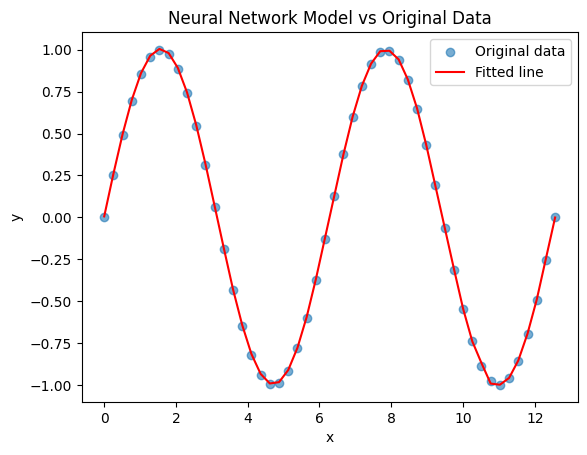

In [29]:
with torch.no_grad():
    predicted = model(X).cpu().detach().data.numpy()

X = X.cpu().detach().data.numpy()
Y = Y.cpu().detach().data.numpy()

plt.scatter(X, Y, label='Original data', alpha=0.6)
plt.plot(X, predicted, label='Fitted line', color='red')
plt.legend()
plt.title('Neural Network Model vs Original Data')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

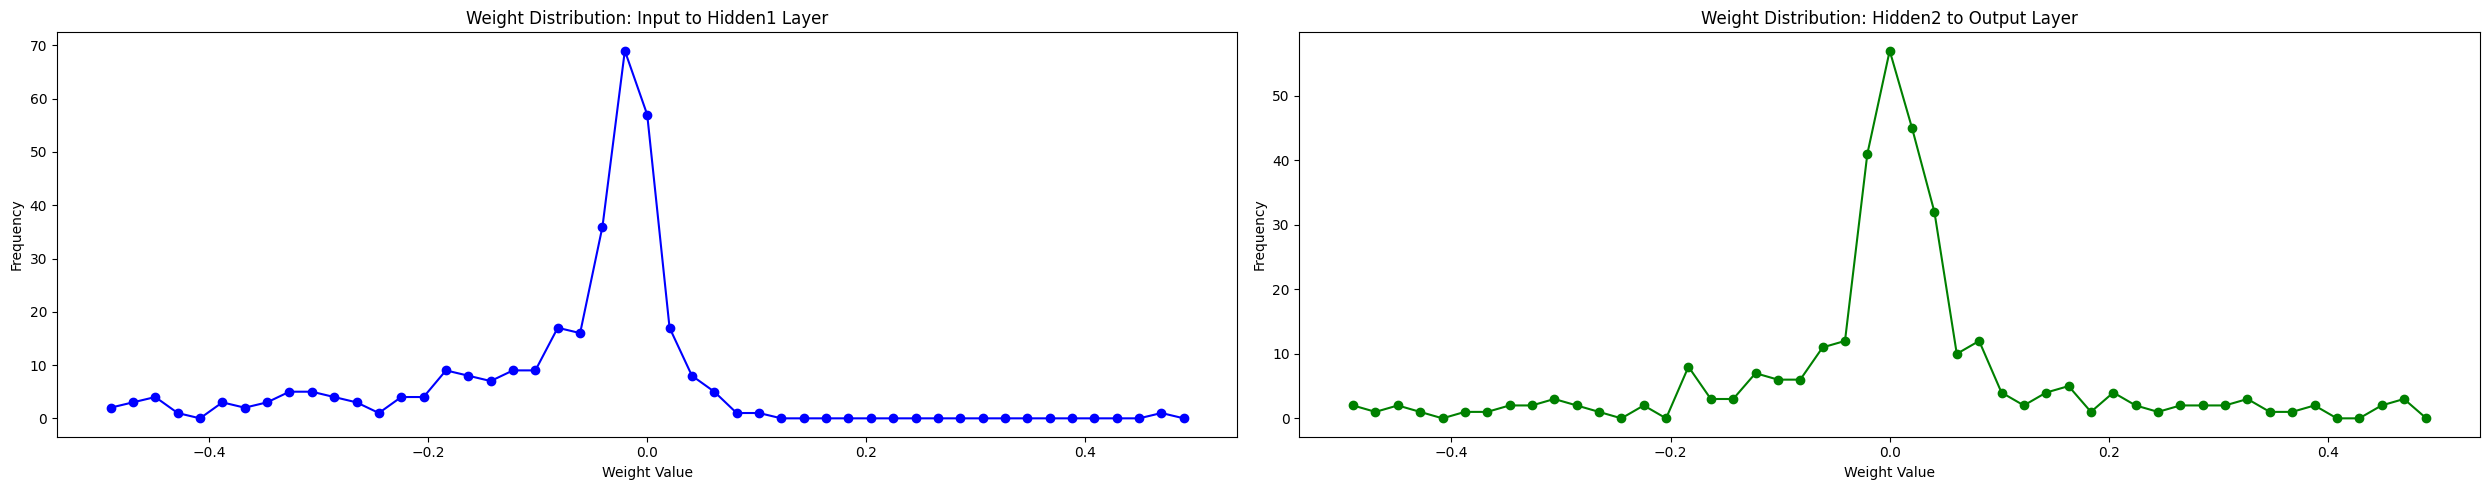

In [30]:
fc_weights = model.fc.weight.cpu().detach().numpy().flatten()
out_weights = model.out.weight.cpu().detach().numpy().flatten()

bins = np.linspace(-0.5, 0.5, 50) 
fc_hist, fc_bins = np.histogram(fc_weights, bins=bins)
out_hist, out_bins = np.histogram(out_weights, bins=bins)

fc_bin_centers = 0.5 * (fc_bins[:-1] + fc_bins[1:])
out_bin_centers = 0.5 * (out_bins[:-1] + out_bins[1:])

plt.figure(figsize=(25, 5))

plt.subplot(1, 2, 1)
plt.plot(fc_bin_centers, fc_hist, marker='o', linestyle='-', color='b')
plt.title('Weight Distribution: Input to Hidden1 Layer')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.plot(out_bin_centers, out_hist, marker='o', linestyle='-', color='g')
plt.title('Weight Distribution: Hidden2 to Output Layer')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [31]:
import torch

def count_nonzero_weights_above_threshold(layer, threshold=0.01):
    return torch.sum(torch.abs(layer.weight) > threshold).item()

threshold_value = 0.01 

nonzero_fc1 = count_nonzero_weights_above_threshold(model.fc, threshold=threshold_value)
nonzero_fc3 = count_nonzero_weights_above_threshold(model.out, threshold=threshold_value)

print(f'Number of non-zero weights greater than {threshold_value} in layer 1: {nonzero_fc1}')
print(f'Number of non-zero weights greater than {threshold_value} in layer 3: {nonzero_fc3}')

Number of non-zero weights greater than 0.01 in layer 1: 265
Number of non-zero weights greater than 0.01 in layer 3: 265
